# Part 5
This notebook was added later, used for validating the results.  
Basically this notebook loads the postprocessed data from `Part1 - Part4` and verifies some scaling relations.  

### First load some references

In [ ]:
#r "BoSSSpad.dll"
// #r "..\..\src\L4-application\BoSSSpad\bin\Release\net5.0\BoSSSpad.dll"
using System;
using System.Collections.Generic;
using System.Linq;
using System.IO;
using System.Data;
using System.Globalization;
using System.Threading;
using ilPSP;
using ilPSP.Utils;
using BoSSS.Platform;
using BoSSS.Foundation;
using BoSSS.Foundation.Grid;
using BoSSS.Foundation.Grid.Classic;
using BoSSS.Foundation.IO;
using BoSSS.Solution;
using BoSSS.Solution.Control;
using BoSSS.Solution.GridImport;
using BoSSS.Solution.Statistic;
using BoSSS.Solution.Utils;
using BoSSS.Solution.Gnuplot;
using BoSSS.Application.BoSSSpad;
using BoSSS.Application.XNSE_Solver;
using static BoSSS.Application.BoSSSpad.BoSSSshell;
using BoSSS.Foundation.Grid.RefElements;
using BoSSS.Platform.LinAlg;
using BoSSS.Application.XNSE_Solver.PhysicalBasedTestcases.PrintingNip;
Init();

#### Check if Output should be generated

Only if the output directories were previously created via `Part0_PrintingNip_Setup` output is stored to the subdirectories.  
Otherwise, datatables are stored directly to the working directory and plots displayed in the notebook.  
The plots are not adjusted to look "nice" in the notebook.  
This is not part of the `ValidationTestRunner`.

In [ ]:
static bool GenerateOutput = Directory.Exists(@"./PrintingNip") && Directory.Exists(@"./PrintingNip/Figures") && Directory.Exists(@"./PrintingNip/Files") && Directory.Exists(@"./PrintingNip/Output");

### Load Datatables

In [ ]:
DataTable tab1, tab2, tab3, tab4;

if(GenerateOutput){
    tab1 = TableExtensions.FromCSVFile("./PrintingNip/Files/PrintingNip-Part1.csv", ColSep: ';');
    tab2 = TableExtensions.FromCSVFile("./PrintingNip/Files/PrintingNip-Part2.csv", ColSep: ';');
    tab3 = TableExtensions.FromCSVFile("./PrintingNip/Files/PrintingNip-Part3.csv", ColSep: ';');
    tab4 = TableExtensions.FromCSVFile("./PrintingNip/Files/PrintingNip-Part4.csv", ColSep: ';');
} else {
    tab1 = TableExtensions.FromCSVFile("./PrintingNip-Part1.csv", ColSep: ';');
    tab2 = TableExtensions.FromCSVFile("./PrintingNip-Part2.csv", ColSep: ';');
    tab3 = TableExtensions.FromCSVFile("./PrintingNip-Part3.csv", ColSep: ';');
    tab4 = TableExtensions.FromCSVFile("./PrintingNip-Part4.csv", ColSep: ';');
}

Number of Rows in `DataTables` and number of sessions should be equal and not empty:  
The Values set here to check the number of sessions depends on the settings in `Part1_*_Run`-`Part4_*_Run`.  
The following is expected:  
* `Part1` : 64 simulations
* `Part2` : 20 simulations
* `Part3` : 72 simulations
* `Part4` : 42 simulations

In [ ]:
BoSSSshell.wmg.Init("PrintingNip_Part1");
int cnt1 = BoSSSshell.wmg.Sessions.Count();
if(cnt1 != 64 || cnt1 != tab1.Rows.Count){
    throw new ApplicationException("Part1: Missing DataRows");
}

In [ ]:
BoSSSshell.wmg.Init("PrintingNip_Part2");
int cnt2 = BoSSSshell.wmg.Sessions.Count();
if(cnt2 != 20 || cnt2 != tab2.Rows.Count){
    throw new ApplicationException("Part2: Missing DataRows");
}

In [ ]:
BoSSSshell.wmg.Init("PrintingNip_Part3");
int cnt3 = BoSSSshell.wmg.Sessions.Count();
if(cnt3 != 72 || cnt3 != tab3.Rows.Count){
    throw new ApplicationException("Part3: Missing DataRows");
}

In [ ]:
BoSSSshell.wmg.Init("PrintingNip_Part4");
int cnt4 = BoSSSshell.wmg.Sessions.Count();
if(cnt4 != 42 || cnt4 != tab4.Rows.Count){
    throw new ApplicationException("Part4: Missing DataRows");
}

### Part1 : Compute some slopes and assert the scaling

First compute the proportionality of some physical values $z \propto \varepsilon^\alpha$ for the simulations in `Part1`.  
Namely the rounded values in Table 1 of `https://doi.org/10.1063/5.0139000` to the first digit i.e. $\pm 0.05$

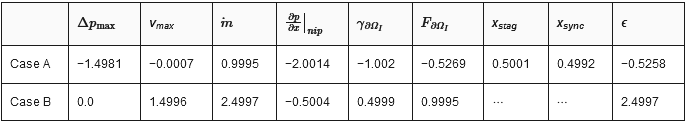

In [ ]:
double thrsh = 0.05;

Case A - dp = 0, V = const, h variable

In [ ]:
double[] ExpectedSlopesA = new double[] {-1.5, 0.0, 1.0, -2.0, -1.0, -0.5, 0.5, 0.5, -0.5};
string[] ColumnsA = new string[] {"PressureRange", "VelocityXMax", "Massflux", "dPdXatNip", "NipShearRateCylinder", "ShearStressCylinder", "PositionOfSynchronousFlow",  "PositionOfStagnatingFlow", "ViscousDissipation"};

In [ ]:
var tab1A = tab1.ExtractRows((i,row) => Convert.ToDouble(row["id:P_Diff"]).ApproxEqual(0.0) && Convert.ToDouble(row["id:V_Wall"])>0.0);

if(tab1A.Rows.Count != 12){ // should be 12
    throw new ApplicationException("Error extracting rows!");
}

foreach(string col in ColumnsA){
    int k = ColumnsA.IndexOf(col);
    var plt = tab1A.ToPlot("id:delta", col, ColName_GroupSelection: new string[] { "id:V_Wall" });
    plt.LogX   = true;
    plt.LogY   = true;
    var reg = plt.Regression();

    int j = 0;
    foreach(var kvp in reg){
        j++;
        if(kvp.Value < ExpectedSlopesA[k] - thrsh || kvp.Value > ExpectedSlopesA[k] + thrsh){
            Console.WriteLine("Expected: {0}, but is {1}", ExpectedSlopesA[k], kvp.Value);
            throw new ApplicationException("Wrong slope computed for " + col);
        } else {
            Console.WriteLine("Expected: {0}, and is {1} - success!", ExpectedSlopesA[k], kvp.Value);
        }
    }

    if(j <= 0){
        throw new ApplicationException("No slopes computed!");
    }
}

Case B - dp = const, V = 0, h variable

In [ ]:
double[] ExpectedSlopesB = new double[] {0.0, 1.5, 2.5, -0.5, 0.5, 1.0, 2.5};
string[] ColumnsB = new string[] {"PressureRange", "VelocityXMax", "Massflux", "dPdXatNip", "NipShearRateCylinder", "ShearStressCylinder", "ViscousDissipation"};

In [ ]:
var tab1B = tab1.ExtractRows((i,row) => Convert.ToDouble(row["id:V_Wall"]).ApproxEqual(0.0) && Convert.ToDouble(row["id:P_Diff"])>0.0);

if(tab1B.Rows.Count != 12){ // should be 12
    throw new ApplicationException("Error extracting rows!");
}

foreach(string col in ColumnsB){
    int k = ColumnsB.IndexOf(col);
    var plt = tab1B.ToPlot("id:delta", col, ColName_GroupSelection: new string[] { "id:P_Diff" });
    plt.LogX   = true;
    plt.LogY   = true;
    var reg = plt.Regression();
    int j = 0;
    foreach(var kvp in reg){
        j++;
        if(kvp.Value < ExpectedSlopesB[k] - thrsh || kvp.Value > ExpectedSlopesB[k] + thrsh){
            Console.WriteLine("Expected: {0}, but is {1}", ExpectedSlopesB[k], kvp.Value);
            throw new ApplicationException("Wrong slope computed for " + col);
        } else {
            Console.WriteLine("Expected: {0}, and is {1} - success!", ExpectedSlopesB[k], kvp.Value);
        }
    }

    if(j <= 0){
        throw new ApplicationException("No slopes computed!");
    }
}

### Part2 : Verify that the stagnation point remains constant and at the expected position

stagnation point is set to $x_s \approx 0.01 m$

In [ ]:
double ExpectedSlope = 0.0;
double ExpectedValue = 0.01;
double AllowedDeviation = 0.0001; 
string Column = "PositionOfStagnatingFlow";

In [ ]:
{
    var plt = tab2.ToPlot("id:delta", Column, ColName_GroupSelection: new string[] { "id:V_Wall" });
    plt.LogX   = true;
    plt.LogY   = true;
    var reg = plt.Regression();

    int j = 0;
    foreach(var kvp in reg){
        j++;
        if(kvp.Value < ExpectedSlope - thrsh || kvp.Value > ExpectedSlope + thrsh){
            Console.WriteLine("Expected: {0}, but is {1}", ExpectedSlope, kvp.Value);
            throw new ApplicationException("Wrong slope computed for " + Column);
        } else {
            Console.WriteLine("Expected: {0}, and is {1} - success!", ExpectedSlope, kvp.Value);
        }
    }
    foreach(var group in plt.dataGroups){
        double IsValue = group.Values.Average();
        if(IsValue < ExpectedValue - AllowedDeviation || IsValue > ExpectedValue + AllowedDeviation){
            Console.WriteLine("Expected: {0}, but is {1}", ExpectedValue, IsValue);
            throw new ApplicationException("Wrong value for " + Column);
        } else {
            Console.WriteLine("Expected: {0}, and is {1} - success!", ExpectedValue, IsValue);
        }
    }

    if(j <= 0){
        throw new ApplicationException("No slopes computed!");
    }
}

### Part3 & 4 not explicitly tested, but with the prior tests it is verified the simulations reproduce the expected results and are runnable